<h2 style="color:darkred;font-size:25px">Projet 6 : Classifiez automatiquement des biens de consommation</h2>

<img src="pictures\logo.png" style="width: 350px;"/>

<h2 style="color:darkred;font-size:25px">Notebook 4 : Computer Vision via Transfer Learning</h2>

---
---
---

<h2 style="color:darkred;font-size:20px">Sommaire</h2>

### Téléchargement du jeux de données

In [1]:
# les libraries nécessaires :

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from wordcloud import WordCloud

In [2]:
# quelques arrangements pour jupyter

# pour voir toutes les colonnes
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 100)

# style de titres
font = {'family': 'Arial',
        'color':  'darkred',
        'weight': 'bold',
        'size': 15,
        }

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P6/data/flipkart_com-ecommerce_sample_1050.csv')
# data = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')

### Ajout de la catégorie principale :

In [5]:
data['categorie_1'] = data['product_category_tree'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()

# 3. Préparation d'ensemble des images

In [6]:
from os import listdir

path = "/content/drive/MyDrive/Colab Notebooks/P6/images/"
list_photos = data['image'].tolist()
list_photos_as_folder = [file for file in listdir(path)]
print(len(list_photos_as_folder))

1050


# 4. Multi modèle

## 4.1. Préparation des données textuelles

In [7]:
data['description'] = data['description'].str.lower()

import nltk

tokenizer = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')

data['tokenized_desc'] = data.apply(lambda row: tokenizer.tokenize(row['description']), axis=1)

In [8]:
# suppresion des stopwords
# suppression de la ponctuation

from nltk.corpus import stopwords

nltk.download("punkt") # punctuation
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

data['clean_tokenized_desc'] = data['tokenized_desc'].apply(lambda x:[word for word in x if word not in stop_words and word.isalnum()])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Longueur maximale des descriptions

max_length = max(data['tokenized_desc'].apply(lambda row : len(row)))
max_length

572

In [10]:
def list_to_string_2 (l):
    string = ', '.join(l)
    #string = string.replace(' ', ', ')
    return string

In [11]:
data['clean_tokenized_desc_0'] = data.apply(lambda row: list_to_string_2(row['clean_tokenized_desc']), axis=1)

In [12]:
# Preprocessing du texte

X = list(data['clean_tokenized_desc_0'])

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max_length)
vectorizer.adapt(X)

In [13]:
# Création du corpus

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [14]:
# Extraction de l'embedding Glove en 100 dimensions
import os

path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/drive/MyDrive/Colab Notebooks/P6/data/glove/glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [15]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4488 words (606 misses)


In [16]:
from sklearn.model_selection import train_test_split

y = data['categorie_1'].astype('category').cat.codes

X_train, X_test, y_train, y_test =train_test_split(list(data['clean_tokenized_desc_0']), y, 
                                                   test_size=0.2, 
                                                   random_state = 0, 
                                                   stratify = y,
                                                   shuffle=True)

In [17]:
from sklearn.model_selection import train_test_split

y = data['categorie_1'].astype('category').cat.codes
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(data['clean_tokenized_desc_0'], y, test_size=0.2, shuffle=True, stratify=y, random_state=2)
_, X_val_nlp, _, y_val_nlp = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=2)


X_train_nlp = vectorizer(np.array([[s] for s in X_train_nlp])).numpy()
X_val_nlp = vectorizer(np.array([[s] for s in X_val_nlp])).numpy()
X_test_nlp = vectorizer(np.array([[s] for s in X_test_nlp])).numpy()


y_train_nlp = np.array(y_train_nlp)
y_val_nlp = np.array(y_val_nlp)
y_test_nlp = np.array(y_test_nlp)


## 4.2. Préparation des images

In [18]:
from tensorflow.keras import preprocessing

def PreprocessingImg(path='/content/drive/MyDrive/Colab Notebooks/P6/images', list_img= list(data.image)) :
#def PreprocessingImg(path='images', list_img= list(data.image)) :
  ### Fonction effectuant le preprocessing nécessaire sur les images ###
  array_img = []

  for img in list_img:
    image = preprocessing.image.load_img(path+ '/' +img, grayscale=False, color_mode="rgb", target_size=[300,300], interpolation="nearest")
    array = preprocessing.image.img_to_array(image)
    array_img.append(array)
  return np.array([array_img])

img_data = PreprocessingImg()

img_array = img_data[0]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [19]:
X_train_img, X_test_img, y_train_img, y_test_img =train_test_split(img_array, y, test_size=0.2, shuffle=True, stratify=y, random_state=2)
_, X_val_img, _, y_val_img =train_test_split(X_train_img, y_train_img, test_size=0.2, shuffle=True, stratify=y_train_img, random_state=2)

In [20]:
# Validation des splits
assert (y_val_img == y_val_nlp).all()
assert (y_test_nlp == y_test_img).all()

In [21]:
# Instanciation de la matrice d'embedding

from tensorflow.keras.layers import Embedding
from tensorflow.keras import initializers

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=initializers.Constant(embedding_matrix),
    trainable=False,
)

In [22]:
# Architecture du modèle multi-inputs

from tensorflow.keras import layers, Input, Model, applications

class_names = data['categorie_1'].unique()

int_nlp = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_nlp)
x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(embedded_sequences)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
model_nlp = Model(int_nlp, x)

vgg16 = applications.vgg16.VGG16
# load model without classifier layers
img_model = vgg16(include_top=False, weights='imagenet', input_shape=(300, 300, 3))

for layer in img_model.layers:
    layer.trainable = False    

# add new classifier layers
y = layers.Flatten()(img_model.layers[-1].output)
y = layers.Dense(1024, activation='relu')(y)

# define new model
model_img = Model(inputs=img_model.inputs, outputs=y)

concat = layers.concatenate([x, y])

z = layers.Dense(1024, activation="relu")(concat)
z = layers.Dropout(0.5)(z)
z = layers.Dense(len(class_names), activation="softmax")(z)

model_double = Model(inputs=[int_nlp, img_model.input], outputs=z)

model_double.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [23]:
# Résumé

model_double.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 300, 300, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 300, 300, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [24]:
# Augmentation de la patience
from tensorflow.keras import callbacks
callback = callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Entraînement du modèle

history_db = model_double.fit(
	x=[X_train_nlp, X_train_img], y=y_train_nlp,  batch_size=32, epochs=50, verbose='auto',
    callbacks=callback, validation_split=0.2, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=32, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)

Epoch 1/50
21/21 [==============================] - 42s 856ms/step - loss: 50.1090 - accuracy: 0.5417 - val_loss: 19.7042 - val_accuracy: 0.7440
Epoch 2/50
21/21 [==============================] - 12s 600ms/step - loss: 7.4736 - accuracy: 0.8393 - val_loss: 13.5430 - val_accuracy: 0.7381
Epoch 3/50
21/21 [==============================] - 12s 594ms/step - loss: 2.6172 - accuracy: 0.9137 - val_loss: 14.3292 - val_accuracy: 0.7679
Epoch 4/50
21/21 [==============================] - 12s 594ms/step - loss: 1.1051 - accuracy: 0.9732 - val_loss: 13.6385 - val_accuracy: 0.7381
Epoch 5/50
21/21 [==============================] - 12s 596ms/step - loss: 1.3397 - accuracy: 0.9643 - val_loss: 13.1607 - val_accuracy: 0.7798
Epoch 6/50
21/21 [==============================] - 12s 600ms/step - loss: 0.8282 - accuracy: 0.9777 - val_loss: 13.5994 - val_accuracy: 0.7857
Epoch 7/50
21/21 [==============================] - 12s 595ms/step - loss: 0.7037 - accuracy: 0.9792 - val_loss: 18.8679 - val_accuracy

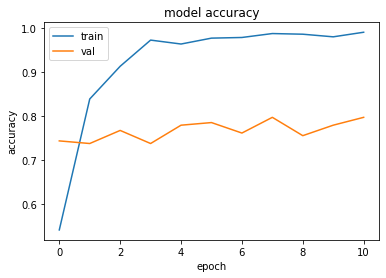

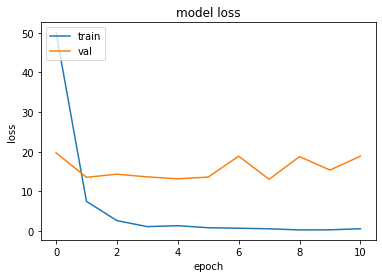

In [25]:
def PlotModel(history, metric='acc', metric_val='val_acc', loss='loss',
              val_loss='val_loss'):  
  ### Graphique des résultats de l'entraînement ###
  plt.plot(history.history[metric])
  plt.plot(history.history[metric_val])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  plt.plot(history.history[loss])
  plt.plot(history.history[val_loss])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

PlotModel(history=history_db, metric='accuracy', metric_val='val_accuracy', loss='loss',
              val_loss='val_loss')

In [26]:
model_double.evaluate(x=[X_test_nlp, X_test_img], y=y_test_nlp, batch_size=32, verbose=2)

7/7 - 13s - loss: 15.0729 - accuracy: 0.8286 - 13s/epoch - 2s/step


[15.072881698608398, 0.8285714387893677]